In [20]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import os
import pandas as pd
from torchvision.io import read_image
from torchvision import transforms
import numpy as np
from torch.utils.data import DataLoader
from torch import nn
import torchvision
import torchvision.transforms as transforms
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import models, transforms
from torchvision.datasets import ImageFolder
from torch.optim.lr_scheduler import StepLR
from sklearn.model_selection import train_test_split

In [21]:
import os
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.normal_dir = os.path.join(root_dir, 'NORMAL')
        self.pneumonia_dir = os.path.join(root_dir, 'PNEUMONIA')
        self.normal_images = [f for f in os.listdir(self.normal_dir) if f.endswith('.jpeg')]
        self.pneumonia_images = [f for f in os.listdir(self.pneumonia_dir) if f.endswith('.jpeg')]
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
        ])

    def __len__(self):
        return len(self.normal_images) + len(self.pneumonia_images)

    def __getitem__(self, idx):
        if idx < len(self.normal_images):
            img_name = os.path.join(self.normal_dir, self.normal_images[idx])
            label = 0  # Normal class
        else:
            idx -= len(self.normal_images)
            img_name = os.path.join(self.pneumonia_dir, self.pneumonia_images[idx])
            if 'bacteria' in self.pneumonia_images[idx]:
                label = 1  # Bacteria class
            elif 'virus' in self.pneumonia_images[idx]:
                label = 2  # Virus class
            else:
                raise ValueError("Invalid image file name in pneumonia folder")
        
        image = Image.open(img_name)
        image = self.transform(image)
        return image, label


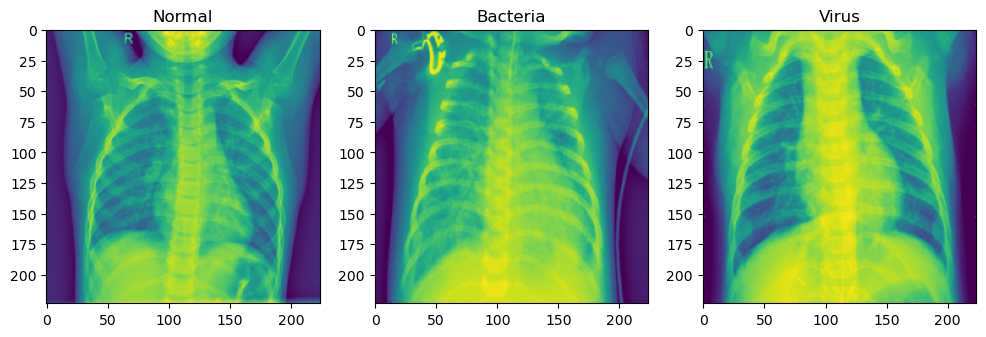

In [22]:
import matplotlib.pyplot as plt

# Create an instance of the custom dataset
dataset = CustomDataset(root_dir='D:\kegll_porject\ChestXRay2017\chest_xray/train')

# Iterate through the dataset and print out sample images and labels
normal_sample = None
bacteria_sample = None
virus_sample = None

# Iterate through the dataset to find one sample image from each class
for i in range(len(dataset)):
    image, label = dataset[i]
    if label == 0 and normal_sample is None:
        normal_sample = (image, label)
    elif label == 1 and bacteria_sample is None:
        bacteria_sample = (image, label)
    elif label == 2 and virus_sample is None:
        virus_sample = (image, label)
    if normal_sample is not None and bacteria_sample is not None and virus_sample is not None:
        break

# Display one sample image from each class
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(normal_sample[0].permute(1, 2, 0))  # Permute dimensions for displaying
plt.title('Normal')

plt.subplot(1, 3, 2)
plt.imshow(bacteria_sample[0].permute(1, 2, 0))  # Permute dimensions for displaying
plt.title('Bacteria')

plt.subplot(1, 3, 3)
plt.imshow(virus_sample[0].permute(1, 2, 0))  # Permute dimensions for displaying
plt.title('Virus')

plt.show()

In [23]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")


Using cuda device


In [55]:
class CustomVerticalCNN(nn.Module):
    def __init__(self, num_classes):
        super(CustomVerticalCNN, self).__init__()
        # Define vertical convolution kernels
        vertical_kernel_1 = [[-1, 0, 1],
                             [-2, 0, 2],
                             [-1, 0, 1]]

        vertical_kernel_2 = [[-1, 0, 1],
                             [-2, 0, 2],
                             [-1, 0, 1]]

        vertical_kernel_3 = [[-1, 0, 1],
                             [-2, 0, 2],
                             [-1, 0, 1]]

        # Convert kernels to torch tensors
        vertical_kernel_1 = torch.tensor(vertical_kernel_1, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
        vertical_kernel_2 = torch.tensor(vertical_kernel_2, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
        vertical_kernel_3 = torch.tensor(vertical_kernel_3, dtype=torch.float32).unsqueeze(0).unsqueeze(0)

        # Define vertical convolutional layers
        self.conv1_v = nn.Conv2d(1, 32, kernel_size=3, padding=1, bias=False)
        self.conv2_v = nn.Conv2d(32, 64, kernel_size=3, padding=1, bias=False)
        self.conv3_v = nn.Conv2d(64, 128, kernel_size=3, padding=1, bias=False)

        # Initialize convolutional layers with vertical kernels
        with torch.no_grad():
            self.conv1_v.weight = nn.Parameter(vertical_kernel_1)
            self.conv2_v.weight = nn.Parameter(vertical_kernel_2)
            self.conv3_v.weight = nn.Parameter(vertical_kernel_3)

        # Other layers remain the same
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(1 * 28 * 28, 512)  # Adjusted the input size of the linear layer
        self.fc2 = nn.Linear(512, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # Vertical convolution layers
        x = self.pool(self.relu(self.conv1_v(x)))
        x = self.pool(self.relu(self.conv2_v(x)))
        x = self.pool(self.relu(self.conv3_v(x)))
        # Flatten the output tensor
        batch_size = x.size(0)
        x = x.view(batch_size, -1)
        
        # Other layers remain the same
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485], std=[0.229])  # Assuming grayscale, so only 1 mean and 1 std
])

train_dataset = ImageFolder('D:\kegll_porject\ChestXRay2017\chest_xray/train', transform=transform)
val_dataset = ImageFolder('D:\kegll_porject\ChestXRay2017\chest_xray/test', transform=transform)

In [56]:
from torch.optim.lr_scheduler import StepLR
train_dataset = ImageFolder('D:\kegll_porject\ChestXRay2017\chest_xray/train', transform=transformo)
val_dataset = ImageFolder('D:\kegll_porject\ChestXRay2017\chest_xray/test', transform=transformo)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

# Initialize model, loss function, and optimizer
model = CustomVerticalCNN(num_classes=len(train_dataset.classes))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)  # Learning rate scheduler



In [57]:
num_epochs = 20
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_loss /= len(train_loader)
    train_accuracy = 100. * correct / total

    # Validate the model
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = 100. * correct / total

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, \
          Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

    # Adjust learning rate
    scheduler.step()

Epoch 1/20, Train Loss: 0.9506, Train Accuracy: 82.70%,           Val Loss: 0.5803, Val Accuracy: 76.76%
Epoch 2/20, Train Loss: 0.2772, Train Accuracy: 88.49%,           Val Loss: 0.4030, Val Accuracy: 83.81%
Epoch 3/20, Train Loss: 0.2570, Train Accuracy: 89.60%,           Val Loss: 0.4112, Val Accuracy: 84.94%
Epoch 4/20, Train Loss: 0.2438, Train Accuracy: 90.00%,           Val Loss: 0.4170, Val Accuracy: 82.21%
Epoch 5/20, Train Loss: 0.2397, Train Accuracy: 90.27%,           Val Loss: 0.7433, Val Accuracy: 73.56%
Epoch 6/20, Train Loss: 0.1978, Train Accuracy: 91.82%,           Val Loss: 0.5476, Val Accuracy: 80.61%
Epoch 7/20, Train Loss: 0.1848, Train Accuracy: 92.78%,           Val Loss: 0.5934, Val Accuracy: 77.72%
Epoch 8/20, Train Loss: 0.1827, Train Accuracy: 92.62%,           Val Loss: 0.6062, Val Accuracy: 78.69%
Epoch 9/20, Train Loss: 0.1728, Train Accuracy: 92.85%,           Val Loss: 0.5924, Val Accuracy: 78.21%
Epoch 10/20, Train Loss: 0.1726, Train Accuracy: 92.79%

In [58]:
torch.save(model.state_dict(), "custom_cnn_vertical_model.pth")